In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import flax.linen as nn
import numpy as np
import jax.numpy as jnp
import jax
import functools

In [3]:
def logpdf(x):
    r = jnp.linalg.norm(x, axis=-1)
    return -(r - 2.6)**2 / 0.033

grad_logpdf = jax.grad(logpdf)

# `grad_logpdf` takes in a single 2D point. We want to be able to
# pass in multiple 2D points for higher throughput.
multi_grad_logpdf = jax.vmap(grad_logpdf, in_axes=(0,))

@functools.partial(jax.jit, static_argnums=(0,))
def langevin_update(grad_func, current_particles, key, epsilon=1e-2):
    key, subkey = jax.random.split(key)
    noise = jax.random.normal(subkey, current_particles.shape)
    next_particles = (
        current_particles
        + epsilon * grad_func(current_particles)
        + jnp.sqrt(2 * epsilon) * noise
    )
    return next_particles, key


def sample_langevin(grad_func, key,
                    num_steps=1000,
                    num_particles=1000,
                    epsilon=1e-2):
    key, subkey = jax.random.split(key)
    particles = jax.random.normal(subkey, (num_particles, 2))

    for t in range(num_steps):
        particles, key = langevin_update(
            grad_func, particles, key, epsilon=epsilon)

    return particles

key = jax.random.PRNGKey(0)
data = sample_langevin(multi_grad_logpdf, key, num_steps=1000, num_particles=10000)
data = np.array(data)

I0000 00:00:1720017275.920198 1128636 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


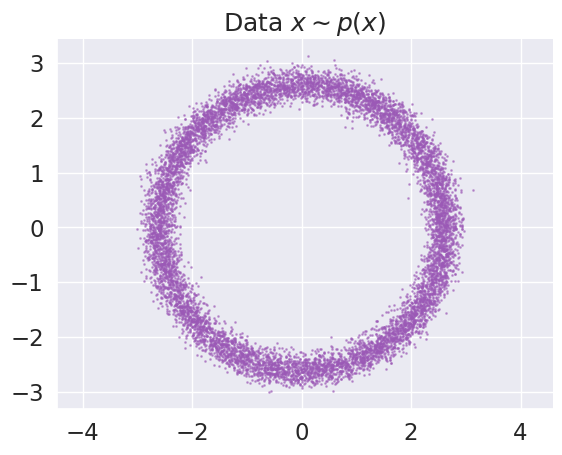

reformatted figures/sampled_data/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [17]:
# Plot the data
import matplotlib.pyplot as plt
from reproducible_figures import (
    set_plotting_style, save_reproducible_figure
)
import pandas as pd


def plot_data(data):
    set_plotting_style(rc={'font.family': 'DejaVu Sans'})
    plt.scatter(data.x, data.y, s=1, alpha=0.5, c="#9b59b6")
    plt.axis("equal")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.title("Data $x \sim p(x)$")


save_reproducible_figure(
    "sampled_data",
    pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]}),
    plot_data,
    show=True
)

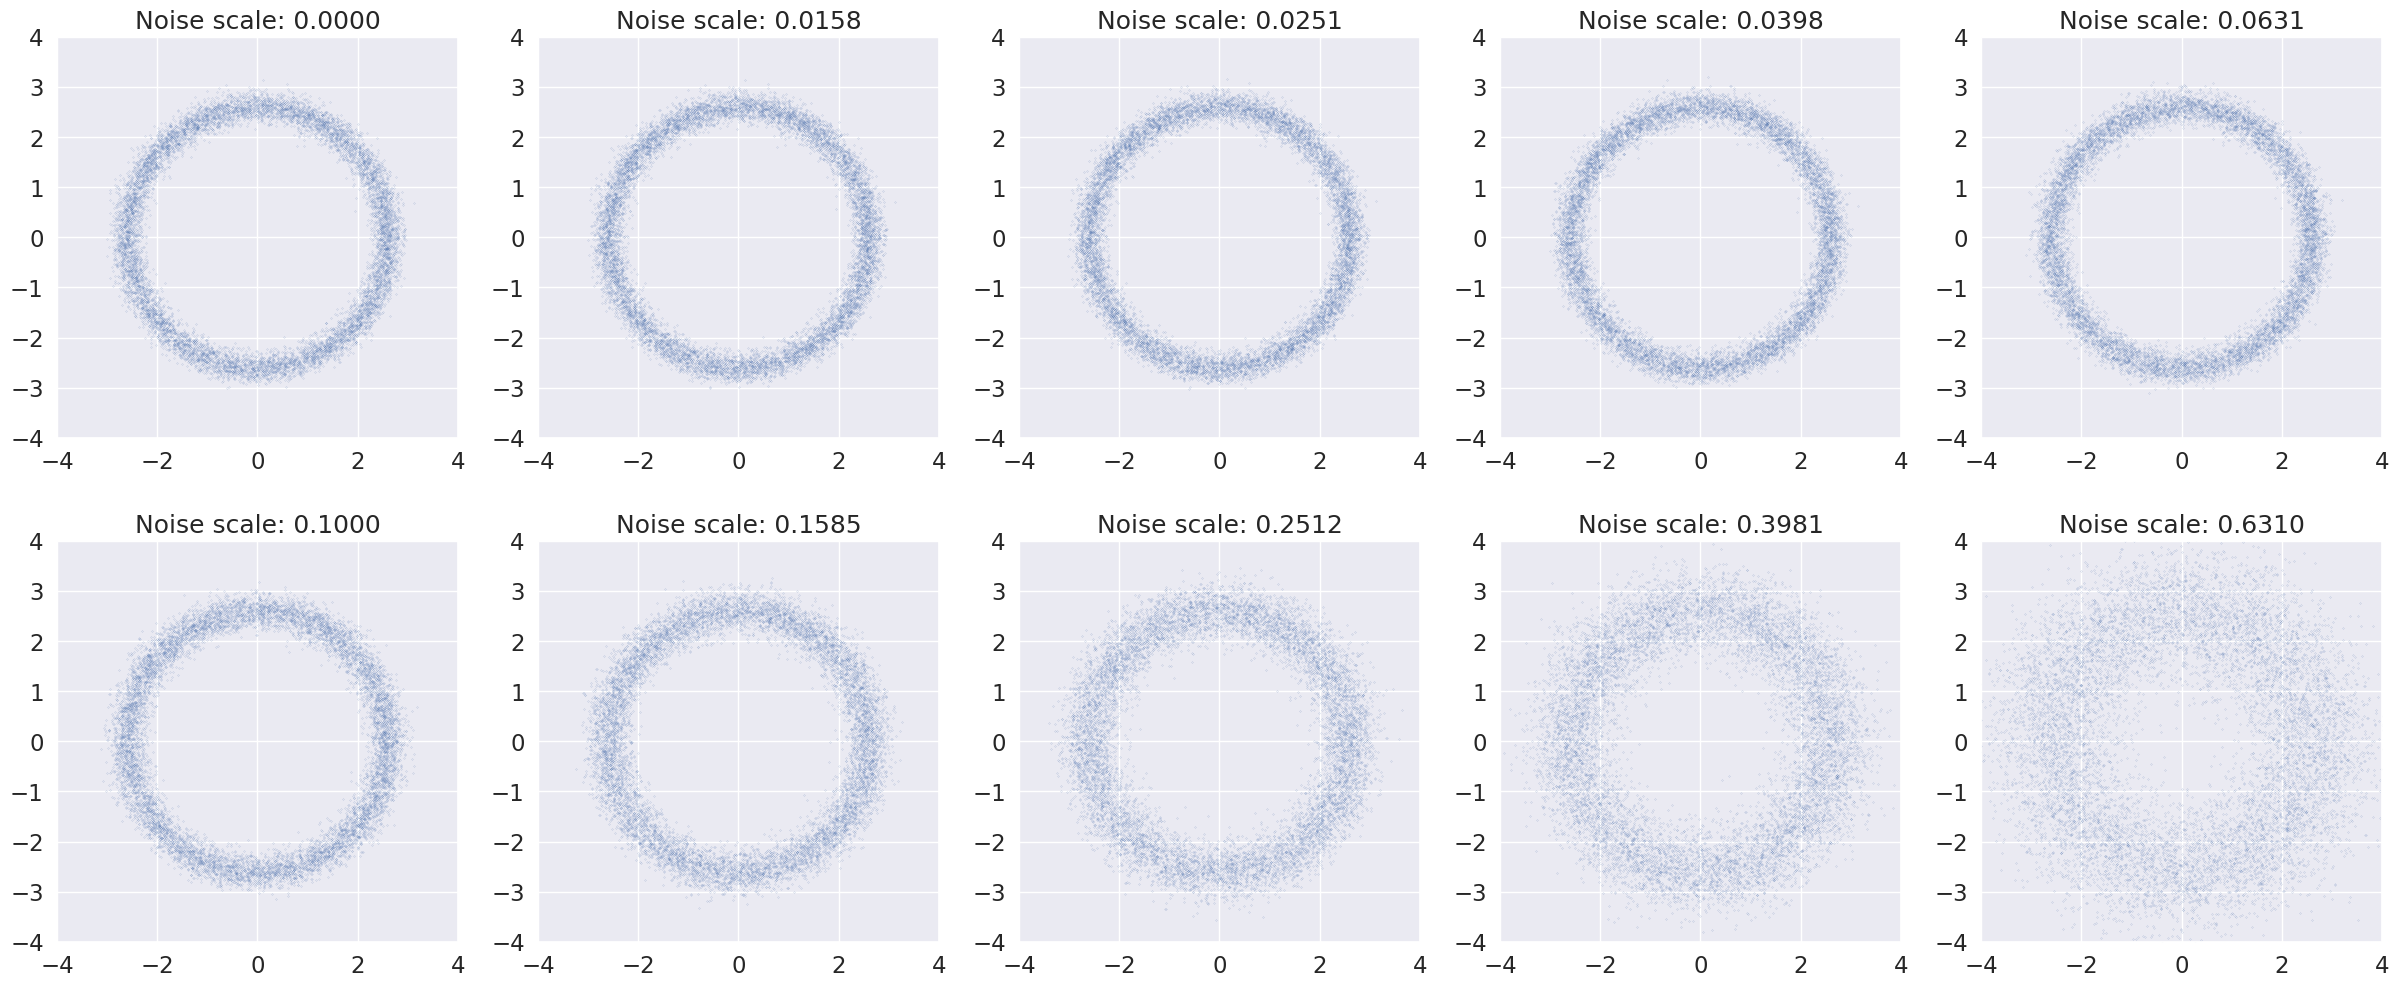

In [21]:
NUM_NOISE_SCALES = 10
NOISE_SCALES = [0.63096**scale_index for scale_index in range(NUM_NOISE_SCALES)][::-1]
FULL_NOISE_SCALES = np.array([0] + NOISE_SCALES)

# Show these in a grid of 2 rows and 5 columns.
fig, axs = plt.subplots(2, 5, figsize=(15 * 2, 6 * 2))

for i, noise_scale in enumerate(FULL_NOISE_SCALES[:-1]):
    noised = data + np.random.normal(0, noise_scale, data.shape)

    ax = axs[i // 5, i % 5]
    ax.scatter(noised[:, 0], noised[:, 1], s=0.01)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

    # Remove spines
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)

    ax.set_title(f"Noise scale: {noise_scale:.4f}")

plt.show()

In [88]:
class DensityModel(nn.Module):
    hidden_size: int = 128

    @nn.compact
    def __call__(self, inputs):
        x, sigmas = inputs
        x = jnp.concatenate([x, sigmas], axis=-1)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)
        y = nn.Dense(1)(x)
        return y.squeeze()


batch_size = 128
num_steps = 20000

JNP_NOISE_SCALES = jnp.array(NOISE_SCALES)
JNP_FULL_NOISE_SCALES = jnp.array(FULL_NOISE_SCALES)
JNP_DATA = jnp.array(data)
N_DATA_SAMPLES = len(data)



def sample_batch(rng):
    rng, _rng = jax.random.split(rng)
    noise_levels = jax.random.randint(_rng, (batch_size // 2,), 0, NUM_NOISE_SCALES)

    pre_sigmas = JNP_FULL_NOISE_SCALES[noise_levels]
    post_sigmas = JNP_FULL_NOISE_SCALES[noise_levels + 1]

    rng, _rng = jax.random.split(rng)
    data_idx_pre = jax.random.choice(_rng, N_DATA_SAMPLES, (batch_size // 2,))
    data_batch_pre = JNP_DATA[data_idx_pre]

    rng, _rng = jax.random.split(rng)
    data_idx_post = jax.random.choice(_rng, N_DATA_SAMPLES, (batch_size // 2,))
    data_batch_post = JNP_DATA[data_idx_post]

    rng, _rng = jax.random.split(rng)
    pre_data = data_batch_pre + pre_sigmas[:, None] * jax.random.normal(_rng, data_batch_pre.shape)
    # post_data = data_batch_post + np.random.normal(0, post_sigmas[:, None], data_batch_post.shape)
    rng, _rng = jax.random.split(rng)
    post_data = data_batch_post + post_sigmas[:, None] * jax.random.normal(_rng, data_batch_post.shape)

    data_batch = jnp.concatenate([pre_data, post_data], axis=0)
    sigmas = jnp.concatenate([post_sigmas, post_sigmas], axis=0)
    return jnp.array(data_batch), jnp.array(sigmas)[:, np.newaxis]

In [89]:
from flax.training.train_state import TrainState
import optax
import chex


def loss_fn(ratios: chex.Array):
    ratios_p = ratios[:batch_size // 2]
    ratios_q = ratios[batch_size // 2:]
    return (
        jnp.mean(-jnp.log(ratios_p / (ratios_p + 1)) 
                 - jnp.log(1 / (ratios_q + 1)))
    )


@jax.jit
def update_fn(state: tuple, _):
    train_state, rng = state

    def compute_loss(params, inputs):
        ratios = jnp.exp(train_state.apply_fn(params, inputs))
        return loss_fn(ratios)

    rng, _rng = jax.random.split(rng)
    inputs = sample_batch(_rng)
    loss, grads = jax.value_and_grad(compute_loss)(train_state.params, inputs)
    new_train_state = train_state.apply_gradients(grads=grads)
    metrics = {'loss': loss}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
inputs = sample_batch(_rng)
density_model = DensityModel()
init_params = density_model.init(_rng, inputs)
optimizer = optax.adam(1e-3)
train_state = TrainState.create(
    apply_fn=density_model.apply,
    params=init_params,
    tx=optimizer
)

(train_state, _), metrics = jax.lax.scan(
    update_fn, (train_state, rng), None, length=num_steps
)

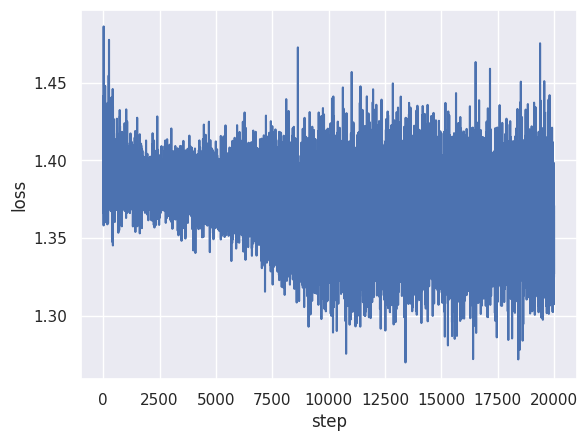

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

df = pd.DataFrame({
    'loss': metrics['loss'],
    'step': np.arange(metrics['loss'].size)
})

sns.lineplot(df, x='step', y='loss')
plt.show()

In [91]:
@jax.vmap
def model_fn(x):
    sigmas = FULL_NOISE_SCALES[1:]
    x = jnp.array([x for _ in sigmas])
    sigmas = jnp.array(sigmas)[:, np.newaxis]
    inputs = (x, sigmas)
    return jnp.exp(jnp.sum(density_model.apply(train_state.params, inputs)))


x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

grid_xs = np.stack([X.ravel(), Y.ravel()], axis=-1)
ratios = model_fn(grid_xs).reshape(X.shape)

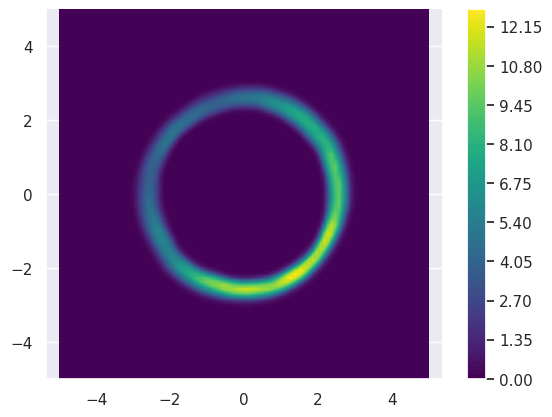

In [92]:
plt.contourf(X, Y, ratios, levels=100, cmap="viridis")
plt.colorbar()
plt.axis("equal")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
